# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

## Содержание проекта
___

[Подготовка](#preparing)<br>
[1.Импорт данных и исследование общей информации](#step1_import_data)<br>
[2. Предобработка данных](#step2_preparing_data)<br>
[2.1. Обработка пропусков](#step2_fill_na)<br>
[2.2. Обработка некорректных или аномальных значений](#step2_incorrect_data)<br>
[2.3. Замена типа данных](#step2_cast_types)<br>
[2.4. Обработка дубликатов](#step2_drop_duplicates)<br>
[2.5. Категоризация данных](#step2_category_data)<br>
[3. Ответы на вопросы](#step3_answer_to_questions)<br>
[3.1 Есть ли зависимость между наличием детей и возвратом кредита в срок?](#step3_question_1)<br>
[3.2. Есть ли зависимость между семейным положением и возвратом кредита в срок?](#step3_question_2)<br>
[3.3. Есть ли зависимость между уровнем дохода и возвратом кредита в срок?](#step3_question_3)<br>
[3.4. Как разные цели кредита влияют на его возврат в срок?](#step3_question_4)<br>
[4. Подведение итогов](#step4_conclusion)<br>

___

<a id='preparing'></a>
# Подготовка

## Импорт библиотек

### Основные библиотеки

In [1]:
import os
import numpy as np
import pandas as pd

### Лемматизация

In [2]:
from pymystem3 import Mystem

### Библиотеки для работы с графиками

In [3]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as ps
import plotly.io as pio

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

d:\python\yandex_praktikum\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Настройки библиотек

In [4]:
# Меняем форматтер для отобраения вещественных чисел, чтобы приятно смотреть было на числа
pd.options.display.float_format = lambda x: f"{x:5,.6g}".replace(",", " ")

In [5]:
#Настраиваем графики
PLOTLY_TEMPLATE = pio.templates["ggplot2"]
PLOTLY_TEMPLATE["layout"].update(margin=dict(l=15,r=15,t=70,b=15,autoexpand=True), height=600, width=1200)
pio.templates.default = PLOTLY_TEMPLATE
pio.renderers.default = "png"
pio.kaleido.scope.default_scale = 1.5

mpl.style.use("ggplot")
mpl.rcParams["figure.figsize"] = 16,8
mpl.rcParams["figure.dpi"] = 96
mpl.rcParams["savefig.dpi"] = 300

<a id='step1_import_data'></a>
# 1. Импорт данных и исследование общей информации

## Описание данных

`children` — количество детей в семье<br>
`days_employed` — общий трудовой стаж в днях<br>
`dob_years` — возраст клиента в годах<br>
`education` — уровень образования клиента<br>
`education_id` — идентификатор уровня образования<br>
`family_status` — семейное положение<br>
`family_status_id` — идентификатор семейного положения<br>
`gender` — пол клиента<br>
`income_type` — тип занятости<br>
`debt` — имел ли задолженность по возврату кредитов<br>
`total_income` — ежемесячный доход<br>
`purpose` — цель получения кредита<br>

In [6]:
data = pd.read_csv("./datasets/data.csv")

Основная информация о данных:

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Делаем случайную выборку из данных

In [8]:
data.sample(n=10, random_state=42)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
423,0,-191.168,56,среднее,1,женат / замужем,0,M,сотрудник,0,138 654,автомобили
3522,0,-2 319.82,58,среднее,1,Не женат / не замужем,4,F,сотрудник,0,123 153,покупка жилья
8760,1,-2 990.58,34,высшее,0,гражданский брак,1,M,компаньон,0,232 381,свадьба
20695,0,-926.209,28,среднее,1,Не женат / не замужем,4,F,сотрудник,0,210 617,получение высшего образования
4351,0,-2 524.3,42,СРЕДНЕЕ,1,женат / замужем,0,F,сотрудник,0,78 487.5,сделка с автомобилем
3002,0,nan,28,высшее,0,женат / замужем,0,M,компаньон,0,nan,покупка жилой недвижимости
17306,0,-5 000.83,0,среднее,1,гражданский брак,1,F,компаньон,0,83 019.1,свадьба
2830,0,-574.996,40,среднее,1,женат / замужем,0,F,сотрудник,0,161 159,автомобили
14822,2,nan,33,среднее,1,женат / замужем,0,F,сотрудник,0,nan,заняться образованием
10347,1,-713.14,48,среднее,1,женат / замужем,0,M,компаньон,0,177 475,ремонт жилью


Оцениваем количество уникальных значений в колонках, это позволит найти колонки с категориальными данными, 
в которых количество значений больше, чем ожидается

In [9]:
data.nunique()

children                8
days_employed       19351
dob_years              58
education              15
education_id            5
family_status           5
family_status_id        5
gender                  3
income_type             8
debt                    2
total_income        19351
purpose                38
dtype: int64

В колонке `gender` 3 значений, вместо ожидаемых 2х.  
Изучим данные подробнее, выведя уникальные значения каждой из колонок

In [10]:
num_vals = [data[col].value_counts() for col in data]
for name_col, Vals in zip(data, num_vals):
    print(f"\n{name_col}:\n\n {Vals.sort_index()}")


children:

 -1        47
 0     14149
 1      4818
 2      2055
 3       330
 4        41
 5         9
 20       76
Name: children, dtype: int64

days_employed:

 -18 388.9    1
-17 615.6    1
-16 593.5    1
-16 264.7    1
-16 119.7    1
            ..
401 664      1
401 674      1
401 675      1
401 716      1
401 755      1
Name: days_employed, Length: 19351, dtype: int64

dob_years:

 0     101
19     14
20     51
21    111
22    183
23    254
24    264
25    357
26    408
27    493
28    503
29    545
30    540
31    560
32    510
33    581
34    603
35    617
36    555
37    537
38    598
39    573
40    609
41    607
42    597
43    513
44    547
45    497
46    475
47    480
48    538
49    508
50    514
51    448
52    484
53    459
54    479
55    443
56    487
57    460
58    461
59    444
60    377
61    355
62    352
63    269
64    265
65    194
66    183
67    167
68     99
69     85
70     65
71     58
72     33
73      8
74      6
75      1
Name: dob_years, dtype: int6

Количественные колонки, в которых большое количество значений, необходимо изучить подробнее

In [11]:
data[["days_employed", "dob_years", "total_income"]].agg(["count", "min", "max", lambda x: x.isna().sum()]).rename(index={"<lambda_0>":'count_nan'})

,days_employed,dob_years,total_income
count,19 351,21525,19 351
min,-18 388.9,0,20 667.3
max,401 755,75,2.2656e+06
count_nan,2 174,0,2 174


## Вывод

 Данные имеют 21525 записи.  
 В колонках `days_employed` и `total_income` имеются пропуски значений.  
    `gender` имеет ошибочное значение *XNA*.  
    `children` имеет некоректное значение *-1*, и сильно отличающееся от других знаение *20*.  
    `days_employed` содержит отрицательные значения, причем данных значений большинство.      
    `education` содержит строковые данные в разном регистре.  
    `dob_years` содержит значение 0.

<a id='step2_preparing_data'></a>
# 2. Предобработка данных

Приведен строковые признаки к нижнему регистру, убрав таким образом дубликаты. 

In [12]:
# Преобразуем к строковые колонки к одному регистру
data["education"] = data["education"] .str.lower()
data["family_status"] = data["family_status"] .str.lower()
data["income_type"] = data["income_type"] .str.lower()
data["purpose"] = data["purpose"] .str.lower()

Разный регистр у строковых данных может быть обусловлен случайным нажатием клавишы *Caps lock*, личными предпочтениями оператора, выполняющего ввод данных, а так же самого человека, от которого эти данные были получены.

Так как у нас есть колонки, в которых идет строковые значения, а также их id (`education`, `education_id` и `family_status`, `family_status_id`), то было бы неплохо проверить, во всех ли строках таблицы совпадают строковые значения с их id. А также исправить неправильные значения id.

In [13]:
# Составим словари, сопоставляющие строковые значения с id
education_dict = data[["education", "education_id"]].groupby("education").agg(lambda x: x.mode())#.reset_index(drop=False)
family_dict = data[["family_status", "family_status_id"]].groupby("family_status").agg(lambda x: x.mode())#.reset_index(drop=False)

# Исправление неправильных id
data.loc[:, "education_id"] = education_dict.loc[data["education"]].values
data.loc[:, "family_status_id"] = family_dict.loc[data["family_status"]].values


<a id='step2_fill_na'></a>
## 2.1. Обработка пропусков

Пропуски были найдены в колонках `days_employed` и `total_income`. Число непропущенных записей в этих колонках совпадает (*19351*), проверим не коррелируют ли пропуски в данных колонках. А также оценим количество уникальных значений в записях,где есть пропуски, вдруг проявится какая-либо взаимосвязь пропусков с другими колонками.

In [14]:
data.loc[data["days_employed"].isna(), "total_income"].value_counts(dropna=False)

nan    2174
Name: total_income, dtype: int64

In [15]:
data.loc[data["days_employed"].isna(), :].nunique()

children             8
days_employed        0
dob_years           56
education            4
education_id         4
family_status        5
family_status_id     5
gender               2
income_type          5
debt                 2
total_income         0
purpose             38
dtype: int64

Получили, что пропуски в данных колонках коррелируют, когда пропуск в `days_employed`, тогда пропуск и в `total_income`. Но взаимосвязь наличия\отсутствия проспука с информацией в других колонках не прослеживается. Т.е. пропуски попадаются у разных людей.  

Оценим несколько записей с пропущенными значениями

In [16]:
data.loc[data["days_employed"].isna(), :].sample(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
17777,0,nan,47,среднее,1,женат / замужем,0,F,сотрудник,0,nan,покупка жилья
14905,0,nan,65,высшее,0,не женат / не замужем,4,F,сотрудник,0,nan,покупка своего жилья
3348,0,nan,44,высшее,0,не женат / не замужем,4,M,компаньон,0,nan,покупка жилья
16519,1,nan,28,среднее,1,женат / замужем,0,M,компаньон,0,nan,на покупку своего автомобиля
13645,1,nan,41,среднее,1,гражданский брак,1,F,сотрудник,0,nan,жилье
14148,1,nan,37,среднее,1,в разводе,3,F,сотрудник,0,nan,получение образования
19654,1,nan,37,высшее,0,в разводе,3,F,сотрудник,0,nan,операции с недвижимостью
5904,0,nan,50,среднее,1,в разводе,3,F,сотрудник,0,nan,на покупку своего автомобиля
17707,0,nan,36,среднее,1,женат / замужем,0,M,сотрудник,1,nan,строительство недвижимости
241,0,nan,47,среднее,1,женат / замужем,0,M,сотрудник,0,nan,строительство собственной недвижимости


В целом, в записях, где есть пропуски, остальная информация корректна. Только странно, что информация о типе занятости (*income_type*) сохранена. Возможно пропуски связаны с тем, что этим людем запрещено раскрывать информацию о доходах и стаже, или они просто отказались её сообщить.  

In [17]:
data_income = data[["total_income"]].copy()

Посмотрим на гистограмму доходов, для наглядности ограничимся уровнем доходов до 600 000:

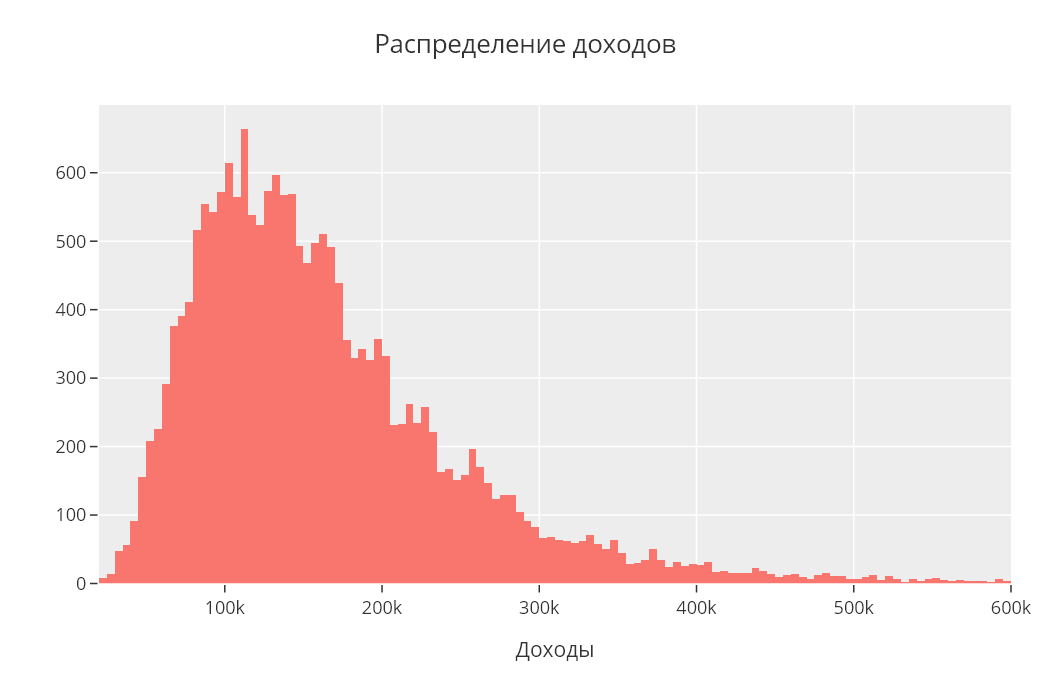

In [18]:
fig = px.histogram(data.query("total_income <= 600_000"), x="total_income", title="Распределение доходов")
fig.update_layout(xaxis=dict(title="Доходы"), yaxis=dict(title=""))

Хотелось бы сохранить данное распределение при заполнении пропусков (т.к. число пропусков не велико, поэтому они не могли сильно повлиять на картину распределения значений доходов), поэтому пропуски будем заполнять случайно выбранными значениями из имеющихся значений, колонку `days_employed` трогать не будем.

In [88]:
val = data.loc[data["total_income"].notnull(), "total_income"].sample(n=data["total_income"].isna().sum())
val.set_axis(data[data["total_income"].isna()].index, axis="index", inplace=True)

In [89]:
data["total_income"].notnull().sum()

19351

Пропуски устранены.

Посмотрим на то, как изменилось распределение значений доходов:

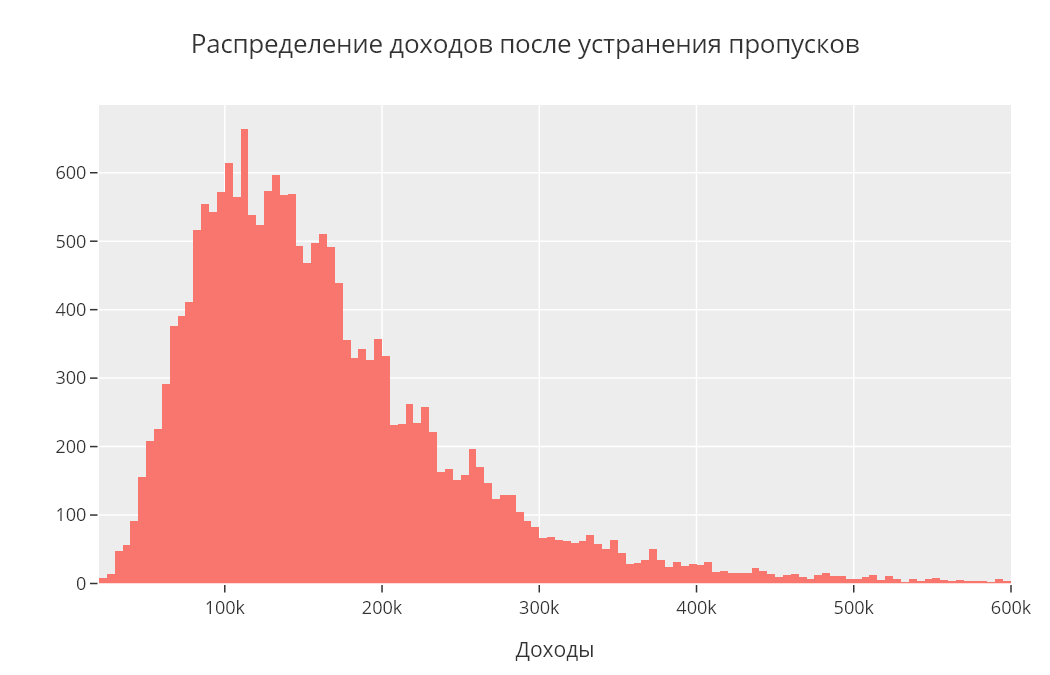

In [90]:
fig = px.histogram(data.query("total_income <= 600_000"), x="total_income", title="Распределение доходов после устранения пропусков")
fig.update_layout(xaxis=dict(title="Доходы"), yaxis=dict(title=""))

Распределения до и после заполнения пропусков похожи.

Оценим, как изменится распределение, если заполнить пропуски медианой:

In [91]:
data_income["total_income"].fillna(value=data_income["total_income"].median(),  inplace=True)

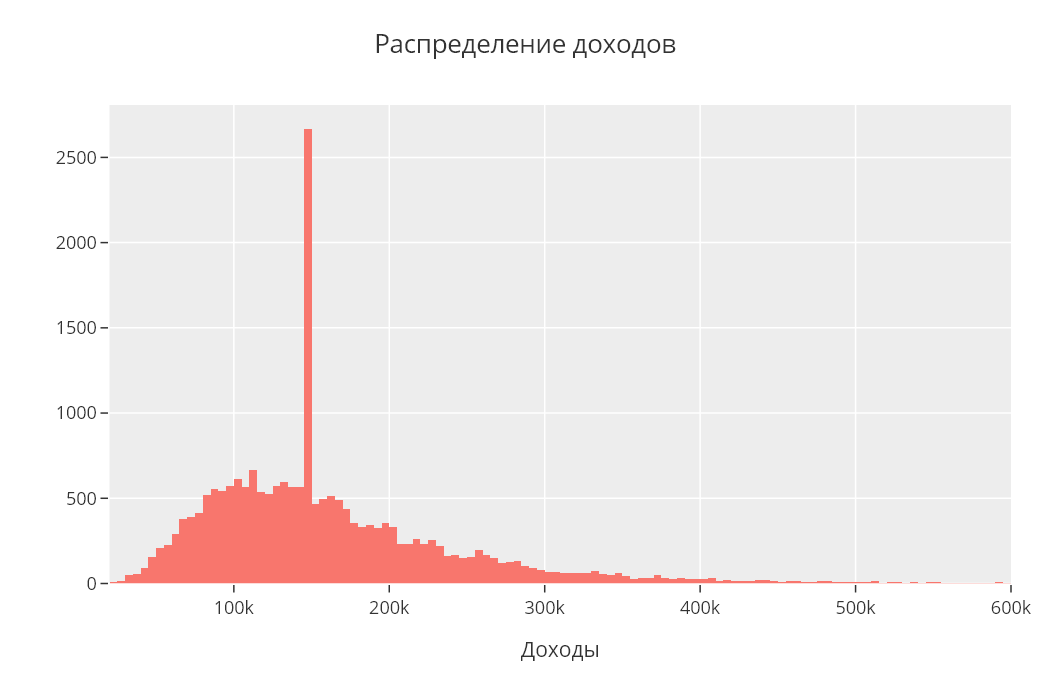

In [92]:
fig = px.histogram(data_income.query("total_income <= 600_000"), x="total_income", title="Распределение доходов")
fig.update_layout(xaxis=dict(title="Доходы"), yaxis=dict(title=""))

In [93]:
data_income["total_income"].value_counts(dropna=False)

145 018     2175
112 874        1
104 382        1
182 037        1
122 422        1
            ... 
133 299        1
115 081        1
84 896.8       1
153 839        1
150 014        1
Name: total_income, Length: 19351, dtype: int64

Видим сильный выброс на гистограмме, что не очень хорошо.

Можно попробовать заполнить пропуски не единой медианой, а в соответствии с типом занятости и/или возрастной группой. Тогда у нас будет множество значений:

In [94]:
category_age = { "0-10": 10,
                "11-20": 20,
                "21-30": 30,
                "31-40": 40,
                "41-50": 50,
                "51-60": 60,
                "61-70": 70,
                "71-80": 80}
def cat_dob_years(value):
    for Cat, AgeHigh in category_age.items():
        if value <= AgeHigh: break
    else: 
        return pd.np.nan
    return Cat
        

In [95]:
data_for_pivot_income = data.loc[:,["total_income", "dob_years", "income_type"]].copy()
data_for_pivot_income["dob_years_category"] = data_for_pivot_income["dob_years"].apply(cat_dob_years)

In [96]:
pivot_total_income = data_for_pivot_income.pivot_table(values="total_income", columns=["dob_years_category"],index=["income_type"], aggfunc="median")
pivot_total_income

dob_years_category,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80
income_type,,,,,,,,
безработный,nan,nan,nan,59 957,202 723,nan,nan,nan
в декрете,nan,nan,nan,53 829.1,nan,nan,nan,nan
госслужащий,125 568,75 787.4,145 626,156 345,149 046,146 205,157 151,122 067
компаньон,190 830,122 802,161 135,181 060,177 203,170 929,182 325,175 868
пенсионер,102 622,nan,80 044.2,115 469,142 125,120 368,115 141,113 417
предприниматель,nan,nan,499 163,nan,nan,nan,nan,nan
сотрудник,144 991,102 231,136 977,145 390,143 450,141 852,147 191,126 538
студент,nan,nan,98 201.6,nan,nan,nan,nan,nan


In [97]:
index_nan = data_for_pivot_income.loc[data_for_pivot_income["total_income"].isna(), ["income_type", "dob_years_category"]]
index_nan

,income_type,dob_years_category
12,пенсионер,61-70
26,госслужащий,41-50
29,пенсионер,61-70
41,госслужащий,41-50
55,пенсионер,51-60
...,...,...
21489,компаньон,41-50
21495,сотрудник,41-50
21497,компаньон,41-50
21502,сотрудник,41-50


In [98]:
fill_nan = []
for inc_type, dob_year in index_nan.iterrows():
    fill_nan.append(pivot_total_income.loc[dob_year.iloc[0], dob_year.iloc[1]])
fill_nan = np.array(fill_nan)
fill_nan = pd.Series(data=fill_nan, index=index_nan.index)

In [99]:
data_for_pivot_income["total_income"].fillna(fill_nan, inplace=True)

In [100]:
data_for_pivot_income.dropna(inplace=True)

In [101]:
data_for_pivot_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21524 entries, 0 to 21524
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_income        21524 non-null  float64
 1   dob_years           21524 non-null  int64  
 2   income_type         21524 non-null  object 
 3   dob_years_category  21524 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 840.8+ KB


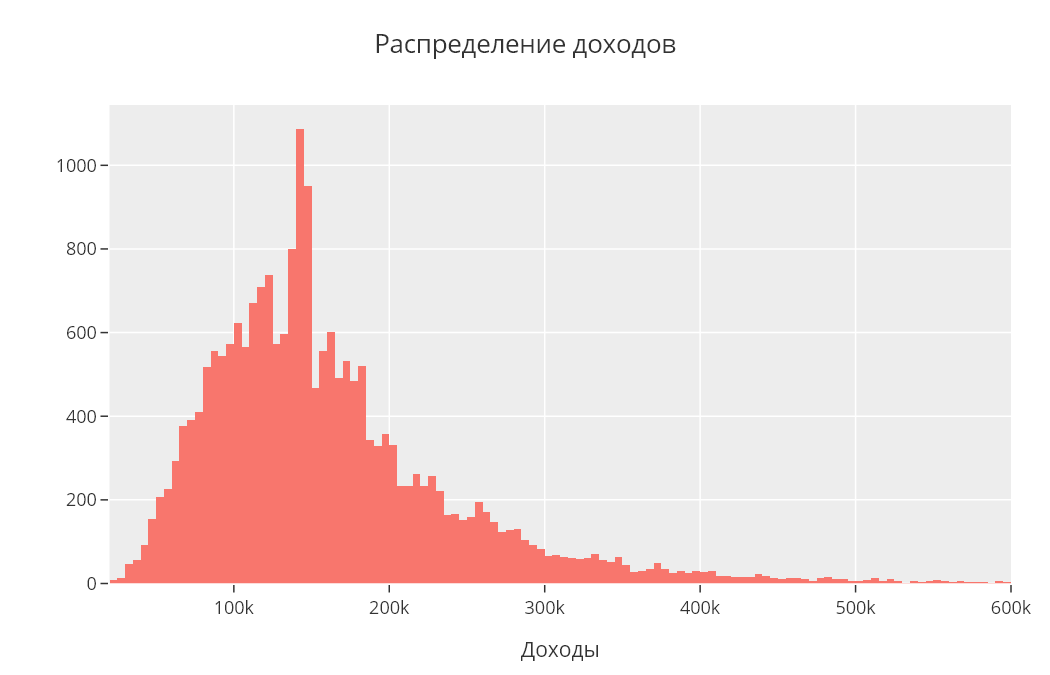

In [102]:
fig = px.histogram(data_for_pivot_income.query("total_income <= 600_000"), x="total_income", title="Распределение доходов")
fig.update_layout(xaxis=dict(title="Доходы"), yaxis=dict(title=""))

Получилось лучше, чем просто заполнение медианой, но что-то всё-равно пики есть.

### Вывод

Заполнили пропуски значениями, сформированными согласно функции распределения доходов.

<a id='step2_incorrect_data'></a>
## 2.2. Обработка некорректных или аномальных значений

Рассмотрим каждую колонку, где встречаются некорректные, или аномальные значения, по отдельности

`children`, некорректное значение *-1*

In [103]:
data[data["children"] == -1].nunique()

children             1
days_employed       44
dob_years           30
education            3
education_id         3
family_status        5
family_status_id     5
gender               2
income_type          4
debt                 2
total_income        44
purpose             30
dtype: int64

In [104]:
data[data["children"] == -1].sample(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
11268,-1,-1 048.78,30,высшее,0,гражданский брак,1,F,компаньон,0,321 604,на покупку автомобиля
10365,-1,345 774,63,высшее,0,вдовец / вдова,2,F,пенсионер,0,170 763,строительство жилой недвижимости
2073,-1,-2 539.76,42,среднее,1,в разводе,3,F,компаньон,0,162 639,покупка жилья
20393,-1,355 157,69,среднее,1,не женат / не замужем,4,F,пенсионер,0,116 521,операции с недвижимостью
10918,-1,340 499,50,среднее,1,женат / замужем,0,M,пенсионер,0,170 763,покупка своего жилья
7190,-1,-5 928.2,34,среднее,1,женат / замужем,0,M,сотрудник,0,184 315,приобретение автомобиля
19417,-1,350 341,28,среднее,1,в разводе,3,F,пенсионер,0,52 873,автомобили
11109,-1,-3 438.46,59,среднее,1,женат / замужем,0,F,сотрудник,0,219 874,операции с жильем
1363,-1,-1 195.26,55,среднее,1,женат / замужем,0,F,компаньон,0,69 550.7,профильное образование
10177,-1,-1 743.6,37,среднее,1,женат / замужем,0,M,сотрудник,0,310 368,получение образования


Записи, у которых значение в поле `children` равно *-1*, имеют корректные значение в остальных колонках,  в них информация разнообразна, не прослеживается связь значений поля `children` с другими полями записей.

Возможно, что значение *-1* - это определенный код, когда человек отказывается сообщить информацию о детях. Поэтому не будем учитывать данные записи при ответе на вопрос : *Есть ли зависимость между наличием детей и возвратом кредита в срок?*

`children`, аномальное значение *20*

In [105]:
data[data["children"] == 20]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
606,20,-880.221,21,среднее,1,женат / замужем,0,M,компаньон,0,145 335,покупка жилья
720,20,-855.596,44,среднее,1,женат / замужем,0,F,компаньон,0,112 999,покупка недвижимости
1074,20,-3 310.41,56,среднее,1,женат / замужем,0,F,сотрудник,1,229 519,получение образования
2510,20,-2 714.16,59,высшее,0,вдовец / вдова,2,F,сотрудник,0,264 475,операции с коммерческой недвижимостью
2941,20,-2 161.59,0,среднее,1,женат / замужем,0,F,сотрудник,0,199 740,на покупку автомобиля
...,...,...,...,...,...,...,...,...,...,...,...,...
21008,20,-1 240.26,40,среднее,1,женат / замужем,0,F,сотрудник,1,133 524,свой автомобиль
21325,20,-601.175,37,среднее,1,женат / замужем,0,F,компаньон,0,102 986,профильное образование
21390,20,nan,53,среднее,1,женат / замужем,0,M,компаньон,0,nan,покупка жилой недвижимости
21404,20,-494.788,52,среднее,1,женат / замужем,0,M,компаньон,0,156 630,операции со своей недвижимостью


Данные записи похожи на ошибку при вводе количества детей, т.к. на цифровой клавиатуре цифры "2" и "0" находятся рядом, и возможно оператор при вводе нажимал сразу две клавиши. На ошибку при вводе указывает и тот факт, что значений *20* больше, чем значений *4* и *5* вместе взятых. Заменим значение "20" на "2".

In [106]:
data["children"].replace(20, 2, inplace=True)
data["children"].value_counts(dropna=False)

 0    14149
 1     4818
 2     2131
 3      330
-1       47
 4       41
 5        9
Name: children, dtype: int64

`dob_years`, некорректное значение *0*

In [107]:
data[data["dob_years"] == 0].nunique()

children             4
days_employed       91
dob_years            1
education            3
education_id         3
family_status        5
family_status_id     5
gender               2
income_type          4
debt                 2
total_income        91
purpose             35
dtype: int64

In [108]:
data[data["dob_years"] == 0].sample(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
15140,2,-4 294.22,0,среднее,1,женат / замужем,0,F,сотрудник,0,81 027.6,покупка жилья для сдачи
2469,0,-794.876,0,среднее,1,гражданский брак,1,F,сотрудник,0,95 967.7,сыграть свадьбу
13968,1,-1 018.53,0,среднее,1,женат / замужем,0,F,сотрудник,1,155 342,свой автомобиль
12297,0,-1 572.05,0,среднее,1,женат / замужем,0,F,сотрудник,0,81 994.5,получение дополнительного образования
14514,0,400 992,0,среднее,1,вдовец / вдова,2,F,пенсионер,0,87 215.4,заняться высшим образованием
10163,0,-4 847.11,0,среднее,1,гражданский брак,1,F,госслужащий,0,97 169.7,свадьба
19116,0,331 559,0,высшее,0,женат / замужем,0,F,пенсионер,0,91 791.9,покупка коммерческой недвижимости
6831,1,-731.397,0,высшее,0,в разводе,3,F,сотрудник,0,247 541,покупка жилья
6848,2,-1 146.69,0,среднее,1,женат / замужем,0,F,сотрудник,0,101 545,приобретение автомобиля
1386,0,-5 043.22,0,высшее,0,женат / замужем,0,M,госслужащий,0,240 524,сделка с автомобилем


Значение *0* в поле `dob_years` скорее всего описывает отказ человека сообщить свой возраст, т.к. остальные данные различны и информативны.  
Удалять, или что-либо изменять в данных запясях не будем, т.к. данная колонка не исползуется в последующем анализе.

<a id='step2_cast_types'></a>
## 2.3. Замена типа данных

Замену типа данных возможно осуществить в колонка `days_employed` и `debt`.  
В `days_employed` возможно изменить тип на целочисленный, так как количество дней стажа должно быть целым. Однако, не будем производить данную замену, т.к. информация из данной колонки в дальнейшем анализе не участвует, но она содержит пропуски значений, и, чтобы преобразовать к целочисленному типу, необходимо заполнить пропуски, чего мы делать не будем.

в `debt` изменим тип на логический.

In [109]:
data['debt'] = data['debt'].astype("?")

In [110]:
data['debt']

0        False
1        False
2        False
3        False
4        False
         ...  
21520    False
21521    False
21522     True
21523     True
21524    False
Name: debt, Length: 21525, dtype: bool

<a id='step2_drop_duplicates'></a>
## 2.4. Обработка дубликатов

Попробуем найти полные дубликаты (изначально удалив строки с пропусками, иначе поиск дубликатов будет некорректным из-за значений NaN)

In [111]:
data.dropna().duplicated().sum()

0

Получили, что полность дублирующих друг друга строк нет.  
Однако, выше было произведено преобразования всех строковых колонок к нижнему регистру, без этого этих колонках были одинаковые значения в разном регистре.  
Отдельно рассмотрим колонку `purpose`.

In [112]:
data["purpose"].value_counts()

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
покупка жилья для сдачи                   653
операции с жильем                         653
операции с коммерческой недвижимостью     651
покупка жилья                             647
жилье                                     647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      624
покупка своего жилья                      620
строительство недвижимости                620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

Видим, что некоторые записи повторяют одну мысль, но имет различный словарный состав. Поэтому произведем лемматизацию данного признака, и с помощью категоризации, распределим все записи по категориям.

Категоризация `purpose`.

In [113]:
# Категории целей
# Ключ - название категории, значение - ключевые слова для данной категории
category_purpose = {"свадьба":{"свадьба"}, "недвижимость":{"недвижимость", "жилье"}, 
                   "автомобиль":{"автомобиль"}, "образование":{"образование"}}

Лемматизация `purpose`.

In [114]:
m = Mystem()

In [83]:
# Функция категоризации purpose
def cat_purpose(value):
    lemm_value = set(m.lemmatize(value))
    for cat_name, cat in category_purpose.items():
        resp =  cat & lemm_value
        if resp:
            break
    else: 
        return pd.np.nan
    return cat_name

In [ ]:
data.insert(12, column="purpose_category", value=data["purpose"].apply(cat_purpose))

In [600]:
# Взглянем на данные
data[["purpose", "purpose_category"]].groupby("purpose_category")["purpose"].value_counts(dropna=False)

purpose_category  purpose                               
автомобиль        на покупку своего автомобиля              505
                  автомобиль                                495
                  сделка с подержанным автомобилем          489
                  свой автомобиль                           480
                  на покупку подержанного автомобиля        479
                  автомобили                                478
                  на покупку автомобиля                     472
                  приобретение автомобиля                   462
                  сделка с автомобилем                      455
недвижимость      операции с недвижимостью                  676
                  покупка коммерческой недвижимости         664
                  операции с жильем                         653
                  покупка жилья для сдачи                   653
                  операции с коммерческой недвижимостью     651
                  жилье                        

In [601]:
print(data[["purpose", "purpose_category"]].groupby("purpose_category")["purpose"].count())
print("Всего:", data[["purpose", "purpose_category"]].groupby("purpose_category")["purpose"].count().sum())

purpose_category
автомобиль       4315
недвижимость    10840
образование      4022
свадьба          2348
Name: purpose, dtype: int64
Всего: 21525


Категоризация прошла успешно, пропущенных значений нет, все цели из колонки `purpose` распределены по категориям.

<a id='step2_category_data'></a>
## 2.5. Категоризация данных

- [x]  По наличию детей - **есть дети\нет детей**;
- [x]  По семейному положению - **есть супруг\супруга или нет**;
- [x]  По уровню образования - **есть высшее\нет высшего**;
- [x]  По доходу - **на 4 категории в соответствие с процентилями 25,50,75,100**;
- [x]  По целям (выполнена выше);

*Категоризация по наличию детей:*

In [602]:
cat_children = ["нет детей", "есть дети"]

In [603]:
# Функция категоризации данных о количестве детей
def cat_children(num_children):
    if num_children == 0:
        return cat_children[0]
    elif num_children > 0:
        return cat_children[1]
    else:
        return pd.np.nan

In [604]:
data.insert(1, column="children_category", value=data["children"].apply(cat_children))

In [605]:
data["children_category"].value_counts(dropna=False)

нет детей    14149
есть дети     7329
NaN             47
Name: children_category, dtype: int64

*Категоризация по семейному положению:*

In [606]:
cat_family = ["в браке", "холост"]

In [607]:
def cat_family(family_id):
    if family_id in [0,1]:
        return cat_family[0]
    elif family_id in [2,3,4]:
        return cat_family[1]
    else:
        return pd.np.nan

In [608]:
data.insert(8, column="family_status_category", value=data["family_status_id"].apply(cat_family))

In [609]:
data["family_status_category"].value_counts(dropna=False)

в браке    16557
холост      4968
Name: family_status_category, dtype: int64

*Категоризация по уровню образования*

In [610]:
data["education"].value_counts(dropna=False)

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

In [611]:
cat_education= ["есть высшее", "нет высшего"]

In [612]:
def cat_education(education_id):
    if education_id in [0, 4]:
        return cat_education[0]
    elif education_id in [1,2,3]:
        return cat_education[1]
    else:
        return pd.np.nan

In [613]:
data.insert(6, column="education_category", value=data["education_id"].apply(cat_education))

In [614]:
data[["education", "education_category"]].groupby("education_category")["education"].value_counts(dropna=False)

education_category  education          
есть высшее         высшее                  5260
                    ученая степень             6
нет высшего         среднее                15233
                    неоконченное высшее      744
                    начальное                282
Name: education, dtype: int64

*Категоризация по уровню дохода, будем её производить по процентилям: 25, 50, 75*

In [615]:
cat_income = {"низкий": data["total_income"].quantile(0.25),
             "средний": data["total_income"].quantile(0.50), 
             "выше среднего": data["total_income"].quantile(0.75),
             "высокий": data["total_income"].max()}


In [616]:
def cat_income(value):
    for Cat, Val in cat_income.items():
        if value <= Val: break
    else:
        return pd.np.nan
    return Cat

In [617]:
data.insert(14, column="total_income_category", value=data["total_income"].apply(cat_income))

In [618]:
data["total_income_category"].value_counts(dropna=False)

низкий           4838
средний          4838
высокий          4838
выше среднего    4837
NaN              2174
Name: total_income_category, dtype: int64

### Вывод

Провели категоризацию интересующих нас данных.  
Удалось распределить большое количество записей в исходных данных на несколько категорий, что позволит сильно упростить нахождение ответов на поставленные вопросы.

<a id='step3_answer_to_questions'></a>
# 3. Ответы на вопросы

<a id='step3_question_1'></a>
## 3.1 Есть ли зависимость между наличием детей и возвратом кредита в срок?

Создадим набор данных для ответа на данный вопрос:

In [619]:
data_of_children = data.loc[data["children"] != -1, ["children", "children_category", "debt"]].copy()

In [620]:
data_of_children["children"].value_counts(dropna=False)

0    14149
1     4818
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

In [621]:
data_of_children["debt"].value_counts(dropna=False)

False    19738
True      1740
Name: debt, dtype: int64

Данные в таблице корректные, можно производить анализ

Сгруппируем данные по категориям наличия\отсутствия детей

In [622]:
group_children = data_of_children.groupby("children_category")
group_children["children"].value_counts(dropna=False)

children_category  children
есть дети          1            4818
                   2            2131
                   3             330
                   4              41
                   5               9
нет детей          0           14149
Name: children, dtype: int64

Найдем вероятноть *не возврата* задолженности по кредиту:

In [623]:
group_children["debt"].mean()

children_category
есть дети    0.092373
нет детей    0.075129
Name: debt, dtype: float64

### Вывод

Получили, что те, у кого ***есть дети*** с большей вероятностью имеют задолженность по кредиту.

<a id='step3_question_2'></a>
## 3.2. Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [624]:
data_of_family = data.loc[:, ["family_status", "family_status_category", "debt"]].copy()

Сгруппируем данные по категориям семейного положения:

In [625]:
group_family = data_of_family.groupby("family_status_category")

In [626]:
group_family["family_status"].value_counts(dropna=False)

family_status_category  family_status        
в браке                 женат / замужем          12380
                        гражданский брак          4177
холост                  не женат / не замужем     2813
                        в разводе                 1195
                        вдовец / вдова             960
Name: family_status, dtype: int64

Найдем вероятноть *не возврата* задолженности по кредиту:

In [627]:
group_family["debt"].mean()

family_status_category
в браке    0.079664
холост     0.084944
Name: debt, dtype: float64

### Вывод

Получили, что ***холостые*** люди с большей вероятностью будут иметь задолженность по кредиту.

<a id='step3_question_3'></a>
## 3.3. Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Создадим набор данных:

In [628]:
data_of_income = data.loc[data["total_income"].notna(), ["total_income_category", "debt"]].copy()

Сгруппируем по категориям доходов с помощью агрегирующей функции среднего значения:

In [629]:
pivot_income = data_of_income.pivot_table(values="debt", index=["total_income_category"],  aggfunc="mean")
pivot_income

,debt
total_income_category,
высокий,0.070484
выше среднего,0.088071
низкий,0.079165
средний,0.087019


### Вывод

Получили, что меньше всего задолженностей у людей с ***высоким*** уровнем дохода, а у людей с доходом ***выше среднего*** чаще других бывают просрочки по платежам. 

<a id='step3_question_4'></a>
## 3.4. Как разные цели кредита влияют на его возврат в срок?

Создаем отдельный набор данные, в который входит только интересующая нас информация:

In [630]:
purpose_data = data.loc[:, ["purpose", "purpose_category", "debt"]].copy()

Создадим сводную таблицу по полученным данным, в качестве агрегирующей функции возьмем среднее значения, это позволит найти вероятность того, что у человека будет задолженность:

In [631]:
purpose_pivot = purpose_data.pivot_table(values="debt", index=["purpose_category"],  aggfunc="mean")
purpose_pivot

,debt
purpose_category,
автомобиль,0.093395
недвижимость,0.072140
образование,0.091994
свадьба,0.079216


### Вывод

Получили, что люди, которые берут кредит на ***автомобиль*** и ***образование***, чаще других имеют задолженности.

<a id='step4_conclusion'></a>
### 4. Подведение итогов

В процессе анализа данных были получены ответы на вопросы о том, как различные окружающие (или бытовые) факторы влияют на платежеспособность человека.   
Однако, анализ проводился по каждому направлению в отдельности (наличие детей, семейное положения, уровень дохода, цель кредита), но некоторые люди могут попадать в одном направлении в категорию, которая имеет меньше задолженностей, а в другом, в категорию людей, которые чаще других просрочивают платежи. Поэтому было бы интересно провести комплексный анализ с учетом всех имеющихся данных. 